**1. Import**

In [ ]:
!pip install pydub

In [ ]:
path = '/content/gdrive/MyDrive/Final_Project/speech_recognition/'
classes = ['yes', 'no', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'up', 'down']

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
import soundfile as sf
import numpy as np
import librosa
from glob import glob
from IPython.display import Audio
from pydub import AudioSegment
import random
from math import sqrt

**2. Creating the dataset**

In [ ]:
import os
import tensorflow as tf
import soundfile as sf
import numpy as np
import librosa

tf_dic_train = {}
tf_dic_val = {}
tf_dic_test = {}
FILES_TO_LOAD = 500

# Read file names from testing_list.txt and validation_list.txt
with open(os.path.join(path, "testing_list.txt"), 'r') as file:
    test_names = file.read().splitlines()
with open(os.path.join(path, "validation_list.txt"), 'r') as file:
    val_names = file.read().splitlines()

for i, label in enumerate(classes):
    train_tmp = []
    val_tmp = []
    test_tmp = []
    for filename in os.listdir(os.path.join(path, label)):
        file_path = os.path.join(path, label, filename)
        if "/".join([label, filename]) in test_names:
            if len(test_tmp) >= FILES_TO_LOAD * 0.1:
                pass
            else:
                audio, sample_rate = librosa.load(file_path, sr=16000)
                audio = librosa.util.fix_length(audio, size=16000)
                test_tmp.append(librosa.feature.mfcc(y=audio, sr=sample_rate))
        elif "/".join([label, filename]) in val_names:
            if len(val_tmp) >= FILES_TO_LOAD * 0.1:
                pass
            else:
                audio, sample_rate = librosa.load(file_path, sr=16000)
                audio = librosa.util.fix_length(audio, size=16000)
                val_tmp.append(librosa.feature.mfcc(y=audio, sr=sample_rate))
        else:
            if len(train_tmp) >= FILES_TO_LOAD * 0.8:
                pass
            else:
                audio, sample_rate = librosa.load(file_path, sr=16000)
                audio = librosa.util.fix_length(audio, size=16000)
                train_tmp.append(librosa.feature.mfcc(y=audio, sr=sample_rate))

    train_tmp_tf = tf.data.Dataset.from_tensor_slices(train_tmp)
    val_tmp_tf = tf.data.Dataset.from_tensor_slices(val_tmp)
    test_tmp_tf = tf.data.Dataset.from_tensor_slices(test_tmp)

    tf_dic_train[label] = tf.data.Dataset.zip((train_tmp_tf, tf.data.Dataset.from_tensor_slices(tf.fill((len(train_tmp_tf),), i))))
    tf_dic_val[label] = tf.data.Dataset.zip((val_tmp_tf, tf.data.Dataset.from_tensor_slices(tf.fill((len(val_tmp_tf),), i))))
    tf_dic_test[label] = tf.data.Dataset.zip((test_tmp_tf, tf.data.Dataset.from_tensor_slices(tf.fill((len(test_tmp_tf),), i))))

datasets_train = list(tf_dic_train.values())
datasets_val = list(tf_dic_val.values())
datasets_test = list(tf_dic_test.values())

In [ ]:
from functools import reduce

def dataset_reduce(datasets):
  merged_dataset_reduce = reduce(lambda d1, d2: d1.concatenate(d2), datasets)
  return merged_dataset_reduce.shuffle(buffer_size=1000)

In [ ]:
datasets_train = dataset_reduce(datasets_train)
datasets_val = dataset_reduce(datasets_val)
datasets_test = dataset_reduce(datasets_test)

In [ ]:
len(datasets_train), len(datasets_val), len(datasets_test)

(5171, 650, 650)

**3. Preprocessing**

In [ ]:
def preprocess_multy(mfcc, label):
  return mfcc, tf.one_hot(label, 13)

In [ ]:
train_data = datasets_train.map(preprocess_multy)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(32)
train_data = train_data.prefetch(16)

In [ ]:
# Validation data:
val_data = datasets_val.map(preprocess_multy)
val_data = val_data.cache()
val_data = val_data.shuffle(buffer_size=1000)
val_data = val_data.batch(32)
val_data = val_data.prefetch(8)

In [ ]:
# Test data:
test_data = datasets_test.map(preprocess_multy)
test_data = test_data.cache()
test_data = test_data.shuffle(buffer_size=1000)
test_data = test_data.batch(32)
test_data = test_data.prefetch(8)

In [ ]:
samples, labels = train_data.as_numpy_iterator().next()
samples.shape, labels.shape

((32, 20, 32), (32, 13))

**4. The model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

model_test_2 = tf.keras.Sequential([
    layers.Reshape((20, 32, 1), input_shape=(20, 32)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(13, activation='softmax')
])

**5. Training the model**

In [ ]:

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=200, decay_rate=0.99, staircase=True)

# Define the optimizer with the learning rate schedule
optimizer_decay = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model_test_2.compile(optimizer=optimizer_decay,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model with callbacks
history = model_test_2.fit(train_data,
                    epochs=100,
                    validation_data=val_data,
                    callbacks=[model_checkpoint])

Epoch 1/100
162/162 [==============================] - 18s 13ms/step - loss: 2.3987 - accuracy: 0.2108 - val_loss: 2.3456 - val_accuracy: 0.2508
Epoch 2/100
162/162 [==============================] - 1s 5ms/step - loss: 1.9655 - accuracy: 0.3334 - val_loss: 1.9692 - val_accuracy: 0.3462
Epoch 3/100
162/162 [==============================] - 1s 5ms/step - loss: 1.5625 - accuracy: 0.4802 - val_loss: 1.6121 - val_accuracy: 0.4938
Epoch 4/100
162/162 [==============================] - 1s 5ms/step - loss: 1.1007 - accuracy: 0.6438 - val_loss: 1.3287 - val_accuracy: 0.6492
Epoch 5/100
162/162 [==============================] - 1s 5ms/step - loss: 0.8463 - accuracy: 0.7389 - val_loss: 1.0689 - val_accuracy: 0.7000
Epoch 6/100
162/162 [==============================] - 1s 6ms/step - loss: 0.6664 - accuracy: 0.8012 - val_loss: 0.8937 - val_accuracy: 0.7369
Epoch 7/100
162/162 [==============================] - 1s 5ms/step - loss: 0.5123 - accuracy: 0.8416 - val_loss: 0.8416 - val_accuracy: 0.76

**6. Results**

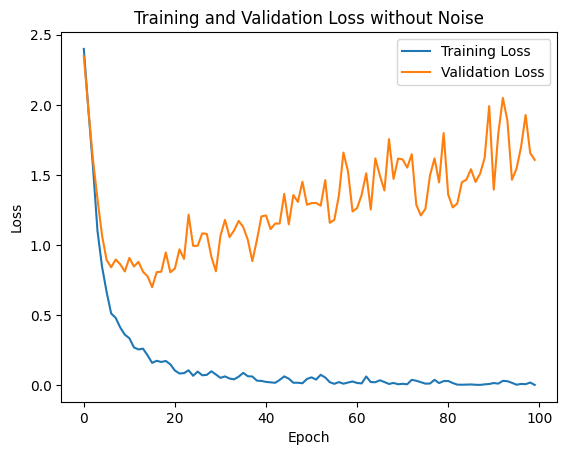

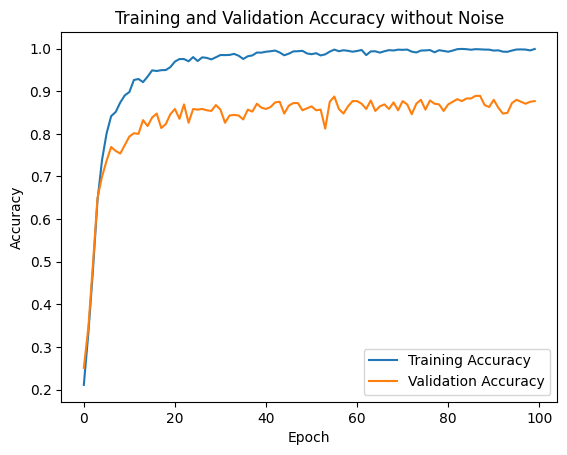

In [ ]:
import matplotlib.pyplot as plt

# Access the loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss without Noise')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy without Noise')
plt.legend()
plt.show()
